# Cross Validation
## With and without cross_val_score()
The purpose of this notebook is to demonstrate what cross_val_score() does behind the scenes, and to be able to emulate it when you need the predictions from each fold.

The [King County housing price dataset](https://www.kaggle.com/harlfoxem/housesalesprediction/data) from Kaggle will be used.

### Common Imports and Notebook Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

The King County Housing Data EDA and preprocessing is in another notebook.

TODO: provide link to that notebook.

In [7]:
# read king county housing data and prepare it for modelling
parser = lambda date: pd.datetime.strptime(date, '%Y%m%dT%H%M%S')
all_data = pd.read_csv('./data/kc_house_data.csv', parse_dates=['date'], date_parser=parser)

# Keep middle 80% by price to improve model accuracy in middle 80%
price = all_data['price']
low, high = price.quantile([0.1, 0.9])
price_filter = (price >= low) & (price <= high)
data = all_data[price_filter]

# compute mean sales price per house (id is house-id)
mean_price_by_id = data.groupby(['id'])['price'].mean()

# convert this to a data frame
mean_price_by_id = pd.DataFrame(mean_price_by_id).reset_index()

# join on id to get a new column for mean price
data = data.merge(right=mean_price_by_id, on='id', suffixes=['_orig', '_mean'])

# drop original price and de-dup the records
data = data.drop('price_orig', axis=1).drop_duplicates(subset='id')

# remove id and date fields
data = data.drop(['id', 'date'], axis=1)

# repace yr_built with yr_renovated if yr_renovated != 0
mask = data['yr_renovated'] != 0
data.loc[mask, 'yr_built'] = data.loc[mask, 'yr_renovated']
data = data.drop('yr_renovated',axis=1)

data = data.drop(['zipcode'], axis=1)

X = data.drop('price_mean', axis=1).values
y = data['price_mean'].values
print(X.shape)
print(y.shape)

(17281, 16)
(17281,)


## Model Building
It seems reasonable that similar houses would have similar prices, so let's try a simple KNN model.

KNN suffers from the "curse of dimensionality" and therefore dimensionality reduction must be used.  PCA is one method.  Here I will use an ExtraTreesClassifier to find the "most important" variables and only use these.

Feature Selection is perhaps the most common way in which data leakage accidentally occurs when creating a model.  Whatever technique is used to select features, must be part of the pipeline within cross-validation to avoid data leakage.

Fortunately Scikit Learn has a meta-estimator designed to make this process easy.

KNN assumes each dimension along which the distance is calculated is weighted the same.  This means that the feature matrix must be scaled prior to creating the KNN model so that each variable is given the same weight in the KNN distance calculation.  The most obvious scaler to use is StandardScaler which transforms the variable to have mean zero and unit variance.  Here I will use QuantileTransformer which is similar but may work better for unusual distributions of the input variable.

The pipeline is:
* build an ExtraTreesRegressor
* select all features that are as least as good as the median importance score
* using this subset of features, standardize them so they have unit variance and zero mean
* build a KNN model

#### Uniform vs Distance Weighting
KNN has an option for how it averages the target values of points it finds in nearby space.  'Uniform' means to average the target value (e.g. housing price) of the K closest points as the prediction.  'Distance" means to perform a weighted average of the K closest points where points further away are weighted less.

### Cross Validation using Pipeline with cross_value_score

In [8]:
# create the feature selector
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
etree = ExtraTreesRegressor(n_jobs=-1, n_estimators=50, random_state=108)
selector = SelectFromModel(etree, threshold='median')

In [9]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
scale = QuantileTransformer(output_distribution='normal', random_state=10)
knn = KNeighborsRegressor(n_neighbors=12, p=2, weights='distance')

pipe = Pipeline(steps=[('selector', selector), ('scale', scale), ('knn',knn)])

# setup an explict cv generator for repeatability
k_folds = 10
random_seed=108
cv = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

In [12]:
# compute the cross validated scores for this pipeline
scores = cross_val_score(pipe, X, y, cv=cv, n_jobs=-1, 
                    scoring='neg_mean_absolute_error')
mad = -scores.mean()
mad

54709.94384627807

### Cross Validation without Pipeline or cross_value_score
The following produces exactly the same result as above.  It takes more lines of code, but it is instructive for understanding how cross_value_score is using the pipeline behind the scenes and demonstrates how to access the test prediction for each fold.

In [13]:
# replace cross_val_score with the following for-loop, no pipeline
from sklearn.metrics import mean_absolute_error
my_scores = []
for train_idx, test_idx in cv.split(X):
    
    # train
    X_train = X[train_idx, :]
    y_train = y[train_idx]
    
    X_train_reduced = selector.fit_transform(X_train, y_train)
    X_train_transformed = scale.fit_transform(X_train_reduced)
    
    # test
    X_test = X[test_idx, :]
    y_test = y[test_idx]
    
    X_test_reduced = selector.transform(X_test)
    X_test_transformed = scale.transform(X_test_reduced)

    # fit model on train
    knn.fit(X_train_transformed, y_train)
    
    # predict on test
    predictions = knn.predict(X_test_transformed)
    
    # evaluate accuracy
    score = mean_absolute_error(y_test, predictions)
    my_scores.append(score)

# print results
mad2 = np.mean(my_scores)
print(mad == mad2)

True


The above code produces exactly the same result as the more concise code that used a pipeline and cross_val_score().

Normally np.isclose() is the preferred equality comparison method for floating point values.  Two floating point values within some small tolerance are often considered equal due to the way math is performed on floating point values.

Here I used '==' to emphasize that the code above must be preforming essentially the same operation as cross_val_score as the floating point values exactly match.

True


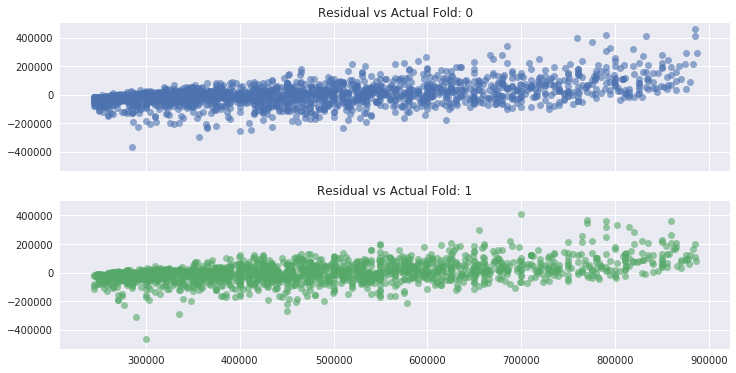

In [18]:
# same as above, but with pipeline for preprocessing
pipe = Pipeline(steps=[('selector', selector), ('scale', scale)])

my_scores = []
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)
for i, (train_idx, test_idx) in enumerate(cv.split(X)):
    
    # train
    X_train = X[train_idx, :]
    y_train = y[train_idx]
    
    X_train_std_pca = pipe.fit_transform(X_train, y_train)
    
    # test
    X_test = X[test_idx, :]
    y_test = y[test_idx]
    
    X_test_std_pca = pipe.transform(X_test)

    # fit model on train
    knn.fit(X_train_std_pca, y_train)
    
    # predict on test
    predictions = knn.predict(X_test_std_pca)
    
    # evaluate accuracy
    my_scores.append(mean_absolute_error(y_test, predictions))
    
    # as we have our own for-loop, we can do anything with the scores for each fold
    # for example, we could plot the residuals per fold
    if i < 2:
        #ax = axes[i//2, i%2]
        ax = axes[i]
        ax.set_title(f'Residual vs Actual Fold: {i}')
        sns.regplot(y = y_test-predictions, x = y_test, fit_reg=False, scatter_kws={'alpha':0.6}, ax=ax)

# print results
mad3 = -scores.mean()
print(mad == mad3)

We see that the residuals are not random.  They increase with increasing price.  This suggests that the model could be improved.